In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.stattools import jarque_bera
from pykalman import KalmanFilter
import yfinance as yf
from math import floor

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
LEVERAGE = 1
INVERT_STRATEGY = False
# Intrady Trading: Buy and sell on the same day
# e.g. Buy on Open, Sell on Close
INTRADAY_TRADING = False
# import ticker
# TICKER = [x, y]
TICKER = ["NWSA", "NWS"]
# TICKER = ["GOOG", "GOOGL"]
START_DATE = '2023-04-01'
END_DATE = '2024-01-01'
prices = yf.download(TICKER+["SPY"], start=START_DATE, end=END_DATE)

prices_close = prices['Close']
prices_close = prices_close.dropna()
prices_close = prices_close[TICKER]


prices = prices['Open']
prices = prices.dropna()

# split into selected ticker and spy
spy = prices['SPY']
prices = prices.drop('SPY', axis=1)
# arrange data in order of ticker
prices = prices[TICKER]

# calculate daily return of SPY
spy_daily_return = spy.pct_change()


[*********************100%***********************]  3 of 3 completed


In [3]:
x = prices[TICKER[0]]
y = prices[TICKER[1]]
delta = 1*10**-3.5
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
# trans_cov =  1e10*np.eye(2) # How much random walk wiggles

obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)), 
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=1,
                  transition_covariance=trans_cov)

# Use the observed values of the price to get a rolling mean
state_means, state_covs = kf.filter(y.values)

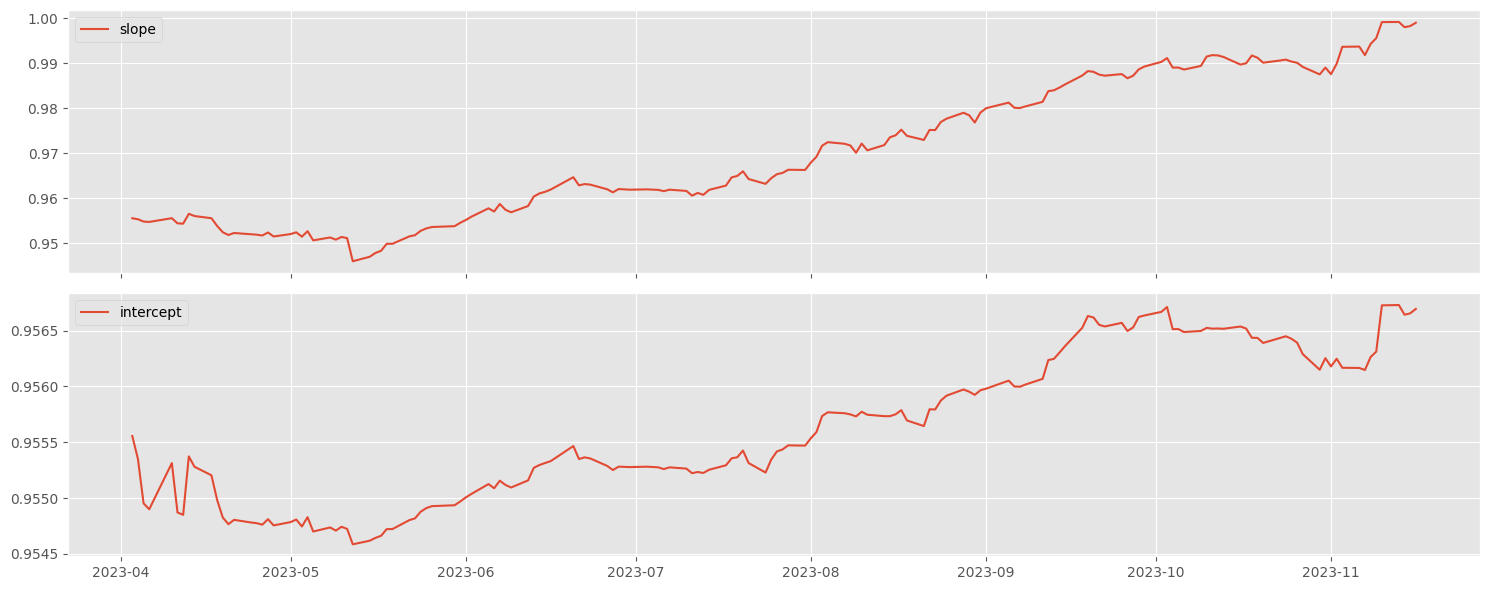

In [4]:
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x.index, state_means[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(x.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout()

Text(0, 0.5, 'NWS')

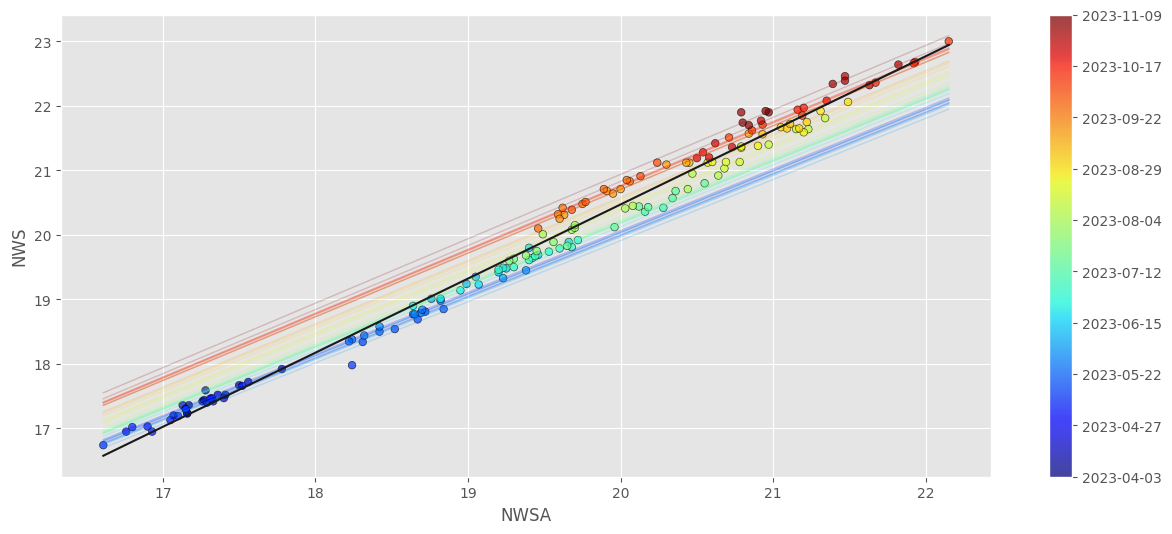

In [5]:
from scipy import poly1d
# Plot data points using colormap
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(x))
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])

# Plot every fifth line
step = 5
xi = np.linspace(x.min(), x.max(), 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))
    
# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x, y, 1))(xi), '0.1')

# Label axes
plt.xlabel(TICKER[0])
plt.ylabel(TICKER[1])

In [6]:
kalman_beta = state_means[:, 0]
#lag beta by 1 day
kalman_beta_lag = np.roll(kalman_beta, 1)
kalman_beta_lag[0] = kalman_beta_lag[1]
kalman_alpha = state_means[:, 1]
kalman_alpha_lag = np.roll(kalman_alpha, 1)
kalman_alpha_lag[0] = kalman_alpha_lag[1]

kalman_spread = prices[TICKER[1]] - kalman_beta_lag * prices[TICKER[0]] - kalman_alpha_lag
# kalman_spread = pd.DataFrame(kalman_spread, columns=['spread'])
#plot rolling spread skippping first 50 days to allow for kalman filter to stabilize
# kalman_spread[:].plot()

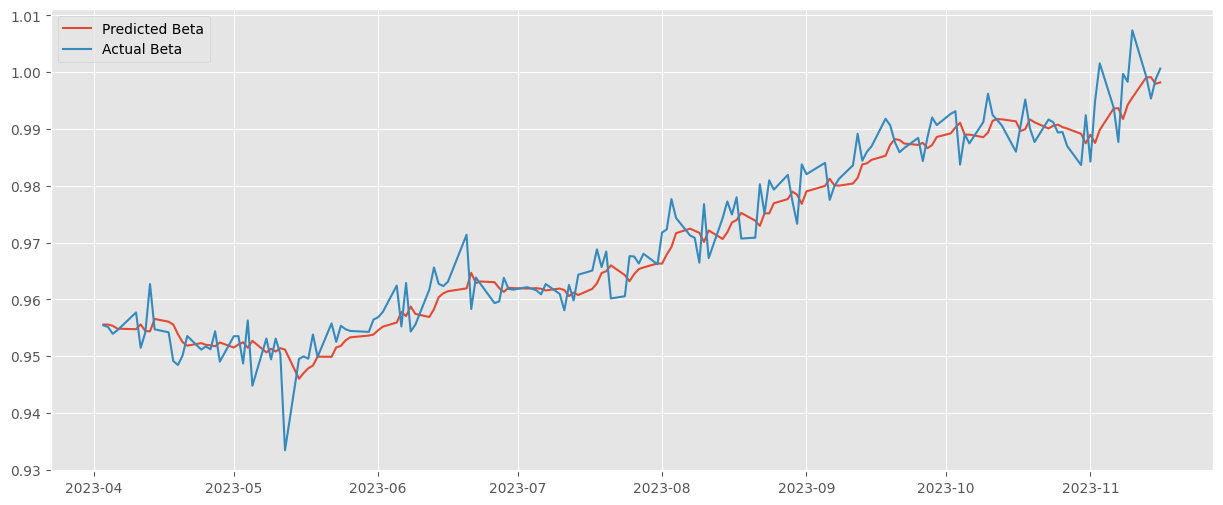

In [7]:
# plot predicted beta against actual daily beta
beta = (y-kalman_alpha_lag)/x
predicted_beta = pd.DataFrame(kalman_beta_lag , index=x.index, columns=['beta'])
plt.plot(predicted_beta, label='Predicted Beta')
plt.plot(beta, label='Actual Beta')
plt.legend()



In [8]:
def statistic_test(resid, to_skip=0):
    # ljung-box test for autocorrelation
    pvalue= sm.stats.acorr_ljungbox(resid[to_skip:])['lb_pvalue'].values[0]
    print("p-value for ljung-box test: {}".format(pvalue))
    if pvalue < 0.05:
        print('Residue is autocorrelated')
    else:
        print('Residue is not autocorrelated')

    #check for normality of spread
    _, pvalue, _, _ = jarque_bera(resid[to_skip:])
    print('p-value for jarque-bera test: {}'.format(pvalue))
    if pvalue < 0.05:
        print('Residue is not normal')
    else:
        print('Residue is normal')
        
    #check for heteroskedasticity of spread 2 sided
    # test whether the variance of the residuals is dependent on the level of the series
    # meaning the variance of the residuals is not constant
    _, pvalue, _, _ = het_arch(resid[to_skip:])
    print('p-value for het_arch test: {}'.format(pvalue))
    if pvalue < 0.05:
        print('Residue is heteroskedastic')
    else:
        print('Residue is not heteroskedastic')


print("===================== All set =====================")
statistic_test(kalman_spread[20:], to_skip=0)
    


===================== All set =====================
p-value for ljung-box test: 0.8206435627132587
Residue is not autocorrelated
p-value for jarque-bera test: 0.0002855819586455181
Residue is not normal
p-value for het_arch test: 0.5169386893181728
Residue is not heteroskedastic


##  spread = GLD - hedgeRatio*GDX

In [9]:
state_vars = kalman_spread.ewm(span=30).var().shift(1)
sqrt_Qt = np.sqrt(state_vars)
e = kalman_spread.values

# Set initial positions to 0
columns = ['positions_'+TICKER[0]+'_long', 'positions_'+TICKER[0]+'_short', 'positions_'+TICKER[1]+'_long', 'positions_'+TICKER[1]+'_short']
for column in columns:
    prices[column] = 0

# Entry conditions based on sqrt_Qt
entry_threshold = 0*sqrt_Qt  # Replace with your specific calculation of sqrt_Qt

# lookback = 30
# let entry threshold be 2 standard deviations from rolling standard deviation
# entry_threshold = 1*spread.rolling(lookback).std()


# Short entry
prices.loc[e > entry_threshold, ('positions_'+TICKER[0]+'_short', 'positions_'+TICKER[1]+'_short')] = [1, -1]

# Long entry
prices.loc[e < -entry_threshold, ('positions_'+TICKER[0]+'_long', 'positions_'+TICKER[1]+'_long')] = [-1, 1]


# Exit conditions based on sqrt_Qt
exit_threshold = 0*sqrt_Qt  # Set your desired exit threshold

# let entry threshold be 1 standard deviations from rolling standard deviation
# exit_threshold = 0*spread.rolling(lookback).std()

# Close short position
prices.loc[e < exit_threshold, ('positions_'+TICKER[0]+'_short', 'positions_'+TICKER[1]+'_short')] = 0

# Close long position
prices.loc[e > -exit_threshold, ('positions_'+TICKER[0]+'_long', 'positions_'+TICKER[1]+'_long')] = 0


# ensure existing positions are carried forward
prices.fillna(method='ffill', inplace=True)


In [10]:
positions_long = prices.loc[:,('positions_'+TICKER[0]+'_long', 'positions_'+TICKER[1]+'_long')]
positions_short = prices.loc[:,('positions_'+TICKER[0]+'_short', 'positions_'+TICKER[1]+'_short')]

positions = np.array(positions_long) + np.array(positions_short)
if INVERT_STRATEGY:
    positions = -positions
positions = pd.DataFrame(positions, index=prices.index, columns=['positions_'+TICKER[0], 'positions_'+TICKER[1]])

positions_sign = positions.copy()

# multiply sposition of TickX by hedge ratio to get amount of TickX to equalize TickY
positions['positions_'+TICKER[0]] = positions['positions_'+TICKER[0]] * kalman_beta_lag

# multiply positions by price to get dollar position
positions["positions_"+TICKER[0]] = positions['positions_'+TICKER[0]] * prices[TICKER[0]]
positions["positions_"+TICKER[1]] = positions['positions_'+TICKER[1]] * prices[TICKER[1]]

In [11]:
# Intraday Trading: Buy and sell on the same day
# In this scenario: Buy on open, sell on close
if INTRADAY_TRADING:
    intraday_daily_returns = (prices_close - prices[TICKER])/prices[TICKER]

    # calculate weighted returns based on positions
    pnl = (np.array(positions) * np.array(intraday_daily_returns)).sum(axis=1)

    daily_used_capital = np.sum(np.abs(positions), axis=1)/2/LEVERAGE
    transaction_pct_cost = 0.0005
    transaction_costs = np.sum(np.abs(positions), axis=1)*transaction_pct_cost

    # Intraday Trading is always daily rebalanced
    # DAILY_REBALANCE = False
    # if not DAILY_REBALANCE:
    #     # ignore transaction costs if positions_sign is not changed from previous day
    #     transaction_costs_bool = (positions_sign == positions_sign.shift()).any(axis=1)
    #     transaction_costs[transaction_costs_bool] = 0

    # subtract transaction costs
    pnl_with_cost = (pnl - transaction_costs)/daily_used_capital
    pnl_with_cost = pnl_with_cost.fillna(0)

    # calculate the percentage returns
    pct_pnl = pnl / daily_used_capital

    # if pnl is nan, set to 0
    pct_pnl = pct_pnl.fillna(0)

else:
    # get daily returns
    daily_returns = prices.pct_change()[TICKER]

    # calculate weighted returns based on positions
    pnl = (np.array(positions.shift()) * np.array(daily_returns)).sum(axis=1)

    daily_used_capital = np.sum(np.abs(positions), axis=1)/2/LEVERAGE
    transaction_pct_cost = 0.0005
    transaction_costs = np.sum(np.abs(positions), axis=1)*transaction_pct_cost

    # TODO: Daily Rebalance is not complete as it has to accoutn for the unchanged positions
    DAILY_REBALANCE = False
    if not DAILY_REBALANCE:
        # ignore transaction costs if positions_sign is not changed from previous day
        transaction_costs_bool = (positions_sign == positions_sign.shift()).any(axis=1)
        transaction_costs[transaction_costs_bool] = 0

    # subtract transaction costs
    pnl_with_cost = (pnl - transaction_costs.shift())/daily_used_capital.shift()
    pnl_with_cost = pnl_with_cost.fillna(0)

    # calculate the percentage returns
    pct_pnl = pnl / daily_used_capital.shift()

    # if pnl is nan, set to 0
    pct_pnl = pct_pnl.fillna(0)

In [12]:
# def rolling_sharpe(pnl, rolling_period=100):
#     return np.sqrt(252) * pnl.rolling(rolling_period).mean() / pnl.rolling(rolling_period).std()


# def rolling_sortino(pnl, rolling_period=100):
#     return np.sqrt(252) * pnl.rolling(rolling_period).mean() / pnl[pnl<0].rolling(rolling_period).std()

# sharpe_list = [0]
# for i in range(1, 100):
#     # test optimal lookback period
#     lookback = i
#     copy = pnl_with_cost.copy()
#     rolling_sharpe_strat = rolling_sortino(copy,lookback)
#     copy[rolling_sharpe_strat.shift(2)<1] = 0
#     sharpe = np.sqrt(252) * copy[1:].mean() / copy[1:].std()
#     sharpe_list.append(sharpe)

# # plot sharpe ratio
# plt.plot(sharpe_list)

# print(max(sharpe_list), np.argmax(sharpe_list))
    

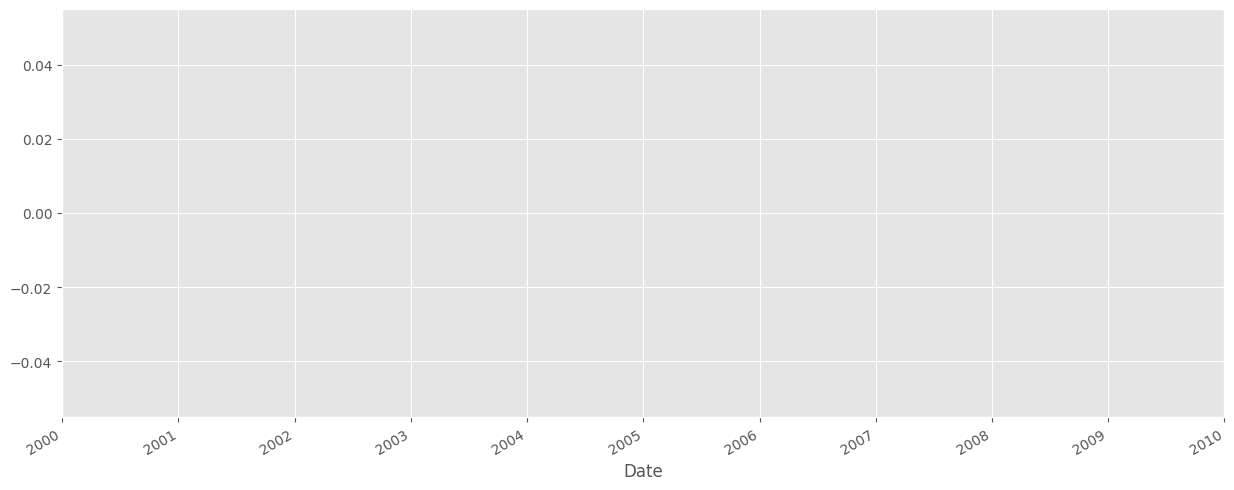

In [13]:
# plot 100 day rolling sharpe ratio

def rolling_sharpe(pnl, rolling_period=100):
    return np.sqrt(252) * pnl.rolling(rolling_period).mean() / pnl.rolling(rolling_period).std()

def rolling_sortino(pnl, rolling_period=100):
    return np.sqrt(252) * pnl.rolling(rolling_period).mean() / pnl[pnl<0].rolling(rolling_period).std()

# set to 0 to ignore sharpe ratio
rolling_period = 0

rolling_sortino(pct_pnl,rolling_period).plot()

# set the pnl to 0 when the rolling sharpe ratio is below 1
rolling_sharpe_strat = rolling_sortino(pct_pnl,rolling_period)

# .shift() to shift the rolling sharpe ratio by 1 day to avoid look ahead bias
# yesterday's rolling sharpe ratio affect today's position decision
positions[rolling_sharpe_strat.shift(1) < 1]= 0

# .shift(2) to shift the rolling sharpe ratio by 2 days to avoid look ahead bias of pnl 
# shift(2) as rolling sharpe affect today's position which affect tomorrow's pnl
pct_pnl[rolling_sharpe_strat.shift(2)<1] = 0
pnl_with_cost[rolling_sharpe_strat.shift(2)<1] = 0


<Axes: xlabel='Date'>

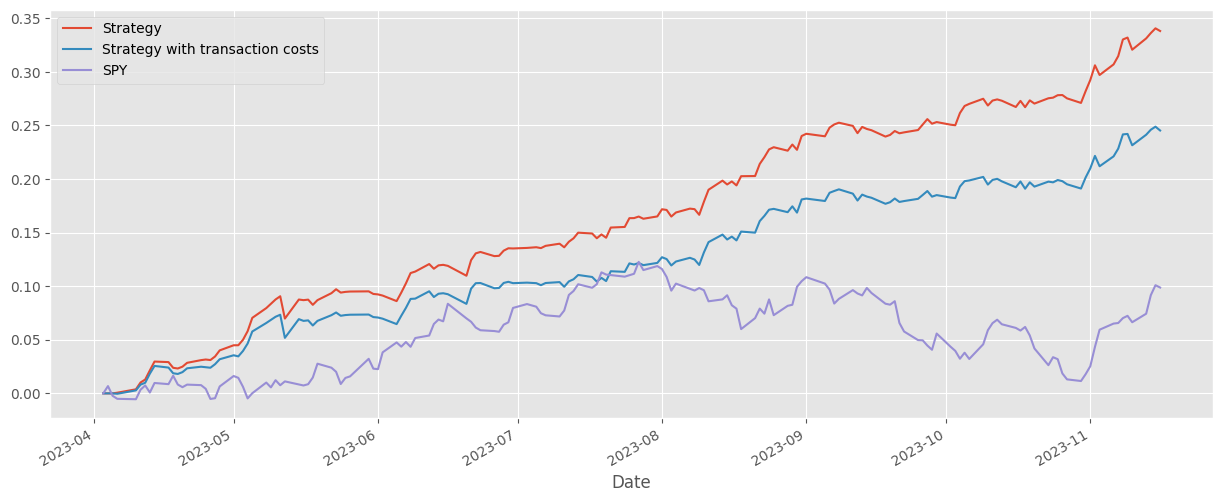

In [14]:
strats = pd.concat([pct_pnl, pnl_with_cost,spy_daily_return.fillna(0)], axis=1)
strats.columns = ['Strategy', 'Strategy with transaction costs', 'SPY']

#create cumulative returns of strategies
strats_cum = (strats + 1).cumprod()-1

#plot cumulative returns
strats_cum.plot()

In [15]:
def calculate_sharpe_ratio(returns :pd.Series) -> float:
    return np.sqrt(252) * returns.mean() / returns.std()

def calculate_sortino_ratio(returns :pd.Series) -> float:
    return np.sqrt(252) * returns.mean() / returns[returns<0].std()

def calculate_drawdown(returns: pd.Series) -> tuple:
    # calculate a cumulative wealth index
    wealth_index = (1 + returns).cumprod()

    # calculate previous peaks
    previous_peaks = wealth_index.cummax()

    # calculate drawdown
    drawdown = (wealth_index - previous_peaks) / previous_peaks
    max_drawdown = drawdown.min()
    max_drawdown_period = drawdown.idxmin()

    return drawdown, max_drawdown, max_drawdown_period

def calculate_annualized_return(returns: pd.Series) -> float:
    cumulative_returns=(1+returns).cumprod()
    n_years = len(cumulative_returns)/252
    return (cumulative_returns.iloc[-1])**(1/n_years)-1

def calmar_ratio(returns: pd.Series) -> float:
    _, max_drawdown, _ = calculate_drawdown(returns)
    annualized_return = calculate_annualized_return(returns)
    return annualized_return / abs(max_drawdown)
    

In [16]:
strat_sets  = {'All': strats}

In [17]:
# calculate sharpe ratio, sortino ratio, drawdown, max drawdown, max drawdown period, annualized return, calmar ratio
sharpe_ratios = {}
sortino_ratios = {}
drawdowns = {}
max_drawdowns = {}
max_drawdown_periods = {}
annualized_returns = {}
calmar_ratios = {}


for key, value in strat_sets.items():
    sharpe_ratio = calculate_sharpe_ratio(value)
    sortino_ratio = calculate_sortino_ratio(value)
    drawdown, max_drawdown, max_drawdown_period = calculate_drawdown(value)
    annualized_return = calculate_annualized_return(value)
    calmar = calmar_ratio(value)
    print(f'=============================={key} set============================================================')
    print(f'Sharpe Ratio:\n{sharpe_ratio}\n')
    print(f'Sortino Ratio:\n{sortino_ratio}\n')
    print(f'Max Drawdown:\n{max_drawdown}\n')
    # print(f'Max Drawdown Period:\n{max_drawdown_period}\n')
    print(f'Annualized Return:\n{annualized_return}\n')
    print(f'Calmar Ratio:\n{calmar}\n')
    print("")
    sharpe_ratios[key] = sharpe_ratio
    sortino_ratios[key] = sortino_ratio
    drawdowns[key] = drawdown
    max_drawdowns[key] = max_drawdown
    max_drawdown_periods[key] = max_drawdown_period
    annualized_returns[key] = annualized_return
    calmar_ratios[key] = calmar





==============================All set============================================================
Sharpe Ratio:
Strategy                           6.150739
Strategy with transaction costs    4.624554
SPY                                1.313724
dtype: float64

Sortino Ratio:
Strategy                           9.583137
Strategy with transaction costs    7.274188
SPY                                2.333066
dtype: float64

Max Drawdown:
Strategy                          -0.019100
Strategy with transaction costs   -0.020100
SPY                               -0.099037
dtype: float64

Annualized Return:
Strategy                           0.586591
Strategy with transaction costs    0.415717
SPY                                0.160954
Name: 2023-11-16 00:00:00, dtype: float64

Calmar Ratio:
Strategy                           30.712045
Strategy with transaction costs    20.682751
SPY                                 1.625185
dtype: float64




In [18]:
# print sharpe ratios
print("==============================Sharpe Ratios ============================================================")
for key, value in sharpe_ratios.items():
    print(f'{key} set: \n{value}\n')

# print sortino ratios
print("==============================Sortino Ratios ============================================================")
for key, value in sortino_ratios.items():
    print(f'{key} set: \n{value}\n')


# print max drawdowns
print("==============================Max Drawdowns ============================================================")
for key, value in max_drawdowns.items():
    print(f'{key} set: \n{value}\n')


# print annualized returns
print("==============================Annualized Returns ============================================================")
for key, value in annualized_returns.items():
    print(f'{key} set: \n{value}\n')

# print calmar ratios
print("==============================Calmar Ratios ============================================================")
for key, value in calmar_ratios.items():
    print(f'{key} set: \n{value}\n')


==============================Sharpe Ratios ============================================================
All set: 
Strategy                           6.150739
Strategy with transaction costs    4.624554
SPY                                1.313724
dtype: float64

==============================Sortino Ratios ============================================================
All set: 
Strategy                           9.583137
Strategy with transaction costs    7.274188
SPY                                2.333066
dtype: float64

==============================Max Drawdowns ============================================================
All set: 
Strategy                          -0.019100
Strategy with transaction costs   -0.020100
SPY                               -0.099037
dtype: float64

==============================Annualized Returns ============================================================
All set: 
Strategy                           0.586591
Strategy with transaction costs    0.415717
SP

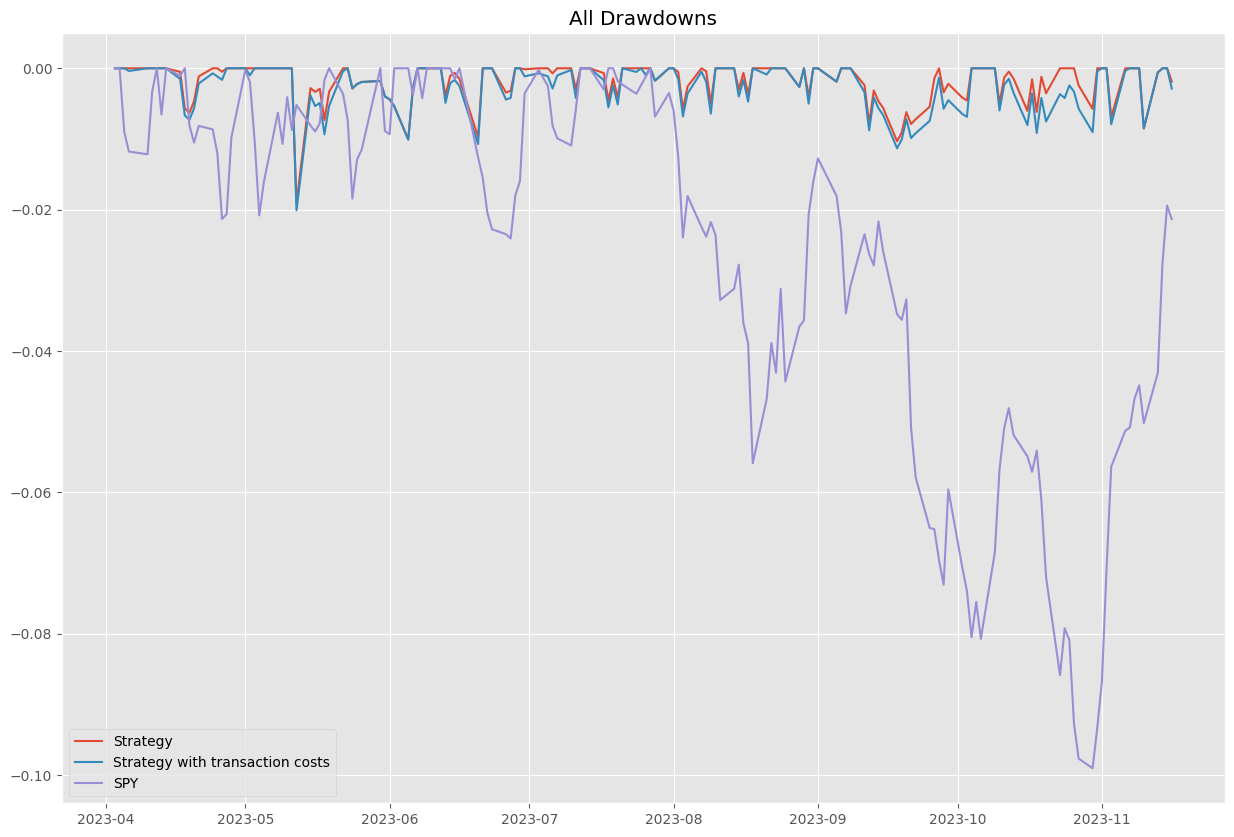

In [19]:
# plot drawdowns
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
ax1.plot(drawdowns['All'])
ax1.legend(['Strategy', 'Strategy with transaction costs', 'SPY'])
ax1.set_title('All Drawdowns')
plt.show()